# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [72]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [73]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

# Q4: Efficient Tracking

## Q4.1: Inverse Composition (15 points)

In [109]:
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage import affine_transform
from numpy.linalg import lstsq
import scipy.signal

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====
    H, W = It.shape
    x = np.arange(0, W)
    y = np.arange(0, H)
    X, Y = np.meshgrid(x, y)

    It_spline = RectBivariateSpline(np.arange(H), np.arange(W), It)
    It1_spline = RectBivariateSpline(np.arange(H), np.arange(W), It1)

    interped_gx = It_spline.ev(Y, X, dx=0, dy=1).flatten()
    interped_gy = It_spline.ev(Y, X, dx=1, dy=0).flatten()

    A = np.zeros((H*W, 6))
    X_flat, Y_flat = X.ravel(), Y.ravel()
    A[:, 0] = interped_gx * X_flat
    A[:, 1] = interped_gx * Y_flat
    A[:, 2] = interped_gx
    A[:, 3] = interped_gy * X_flat
    A[:, 4] = interped_gy * Y_flat
    A[:, 5] = interped_gy

    p = M.flatten()

    for _ in range(num_iters):
        X_warp = p[0] * X + p[1] * Y + p[2]
        Y_warp = p[3] * X + p[4] * Y + p[5]
        valid = (X_warp >= 0) & (X_warp < W) & (Y_warp >= 0) & (Y_warp < H)
        X_warp, Y_warp = X_warp[valid], Y_warp[valid]

        interped_I = It1_spline.ev(Y_warp, X_warp)

        A_valid = A[valid.flatten()]
        b = interped_I.flatten() - It[valid].flatten()

        delta_p, _, _, _ = lstsq(A_valid, b, rcond=None)

        if np.linalg.norm(delta_p) < threshold:
            break

        delta_M = np.array([[1 + delta_p[0], delta_p[1], delta_p[2]],
                            [delta_p[3], 1 + delta_p[4], delta_p[5]],
                            [0, 0, 1]])
        M = M @ np.linalg.inv(delta_M)
        p = M[:2, :].flatten()

    M = M[:2, :]
    # ===== End of code =====
    return M

## Debug Q4.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

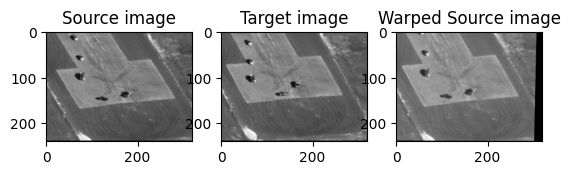

In [110]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("/content/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = InverseCompositionAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

## Q4.2 Tracking with Inverse Composition (10 points)

Re-use your impplementation in Q3.2 for subtract dominant motion. Just make sure to use InverseCompositionAffine within.

In [111]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
    M = InverseCompositionAffine(It, It1, threshold, num_iters)
    warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
    diff_image = np.abs(warped_It - It1)
    mask = diff_image > tolerance
    mask = binary_erosion(mask, structure=np.ones((2, 1)))
    mask = binary_dilation(mask, iterations = 1)
    # ===== End of code =====

    return mask


Re-use your implementation in Q3.3 for sequence tracking.

In [112]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    rects =[]
    It = seq[:,:,0]
    masks =[]

    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i-1]
        It1 = seq[:, :, i]

        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

Track the ant sequence with inverse composition method.


In [113]:
seq = np.load("/content/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [00:42<00:00,  2.94it/s]


Ant Sequence takes 42.346663 seconds


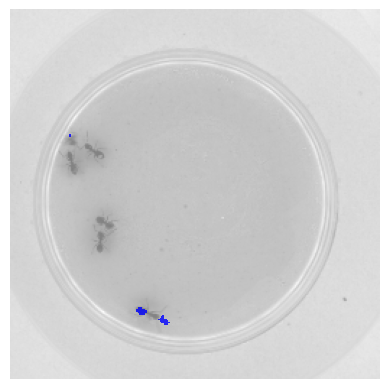

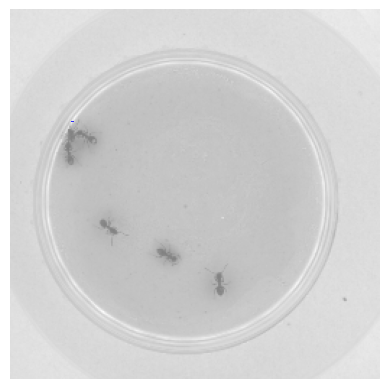

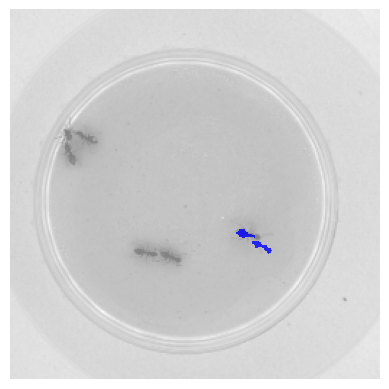

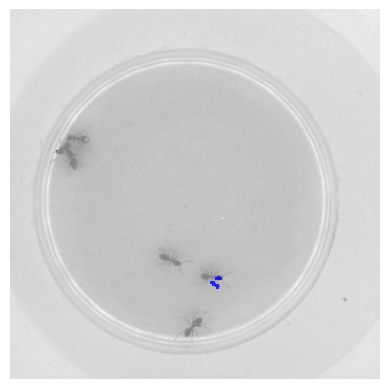

In [114]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


Track the aerial sequence with inverse composition method.


In [115]:
seq = np.load("/content/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [02:00<00:00,  1.23it/s]


Ant Sequence takes 121.023149 seconds


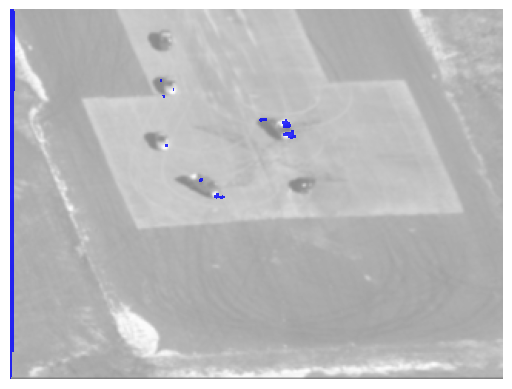

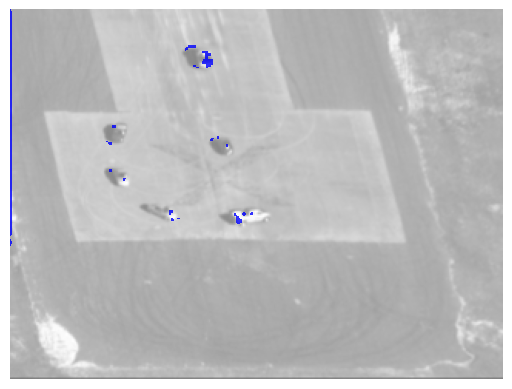

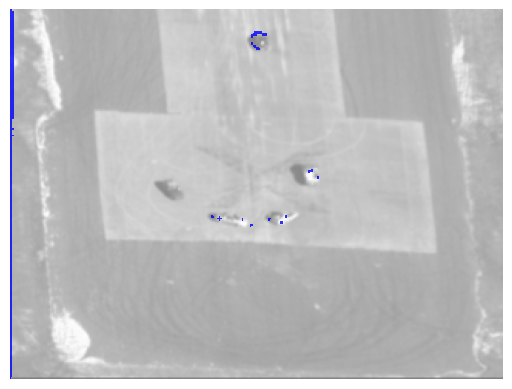

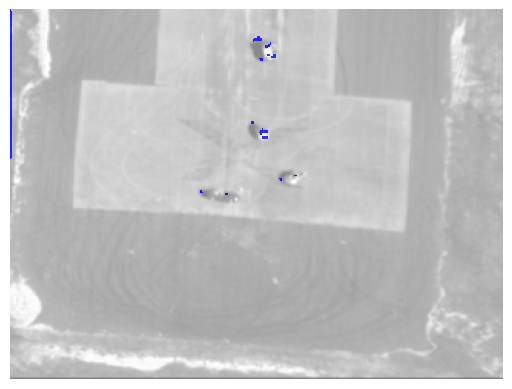

In [116]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')

## Q4.2.1 Compare the runtime of the algorithm using inverse composition (as described in this section) with its runtime without inverse composition (as detailed in the previous section) in the context of the ant and aerial sequences:
===== your answer here! =====

For Ant Sequence Tracking, algorithm without inverse composition takes 1437.214954 seconds, algorithm using inverse composition takes 42.346663 seconds.

For Aerial Sequence Tracking, algorithm without inverse composition takes 496.878964 seconds, algorithm using inverse composition takes 121.023149 seconds.

===== end of your answer ====

## Q4.2.2 In your own words, please describe briefly why the inverse compositional approach is more computationally efficient than the classical approach:
===== your answer here! =====

In inverse compositional approach, the gradient of the template image and the Hessian matrix is pre-computated since that the template image stays fixed, and the warp update is composed with the current warp estimate in the inverse direction.

Also, in inverse approach, updating the warp is typically simpler and can be computated faster, because they avoid the repeated computation of derivatives and matrix inversions on the changing warped image.

===== end of your answer ====